In [ ]:
!pip install numpy scipy scikit-learn matplotlib fbm iisignature joblib
# Optional, for the LSTM baseline comparison:
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for iisignature: filename=iisignature-0.24-cp312-cp312-linux_x86_64.whl size=3246771 sha256=315cbe5f8a82277b73fbe356394639a13b5d5533f40f26a76721a85de8f4654f
  Stored in directory: /root/.cache/pip/wheels/7d/b3/8c/168fb7d3b31255a501dea7fa1f5e5098e63ec61a786eeb0156
Successfully built iisignature


--- Starting Robustness Analysis: 10 runs with different seeds ---

--- Starting Run 1/10 (Seed: 0) ---
   ...Run 1 complete. Exact Path MSE: 1.194

--- Starting Run 2/10 (Seed: 1) ---
   ...Run 2 complete. Exact Path MSE: 0.984

--- Starting Run 3/10 (Seed: 2) ---
   ...Run 3 complete. Exact Path MSE: 1.987

--- Starting Run 4/10 (Seed: 3) ---
   ...Run 4 complete. Exact Path MSE: 1.646

--- Starting Run 5/10 (Seed: 4) ---
   ...Run 5 complete. Exact Path MSE: 0.654

--- Starting Run 6/10 (Seed: 5) ---
   ...Run 6 complete. Exact Path MSE: 0.379

--- Starting Run 7/10 (Seed: 6) ---
   ...Run 7 complete. Exact Path MSE: 0.279

--- Starting Run 8/10 (Seed: 7) ---
   ...Run 8 complete. Exact Path MSE: 0.134

--- Starting Run 9/10 (Seed: 8) ---
   ...Run 9 complete. Exact Path MSE: 0.282

--- Starting Run 10/10 (Seed: 9) ---
   ...Run 10 complete. Exact Path MSE: 0.169


--- AGGREGATED STATISTICAL RESULTS ---
This is the robust results table for your paper:
               Pathwise MSE (Me

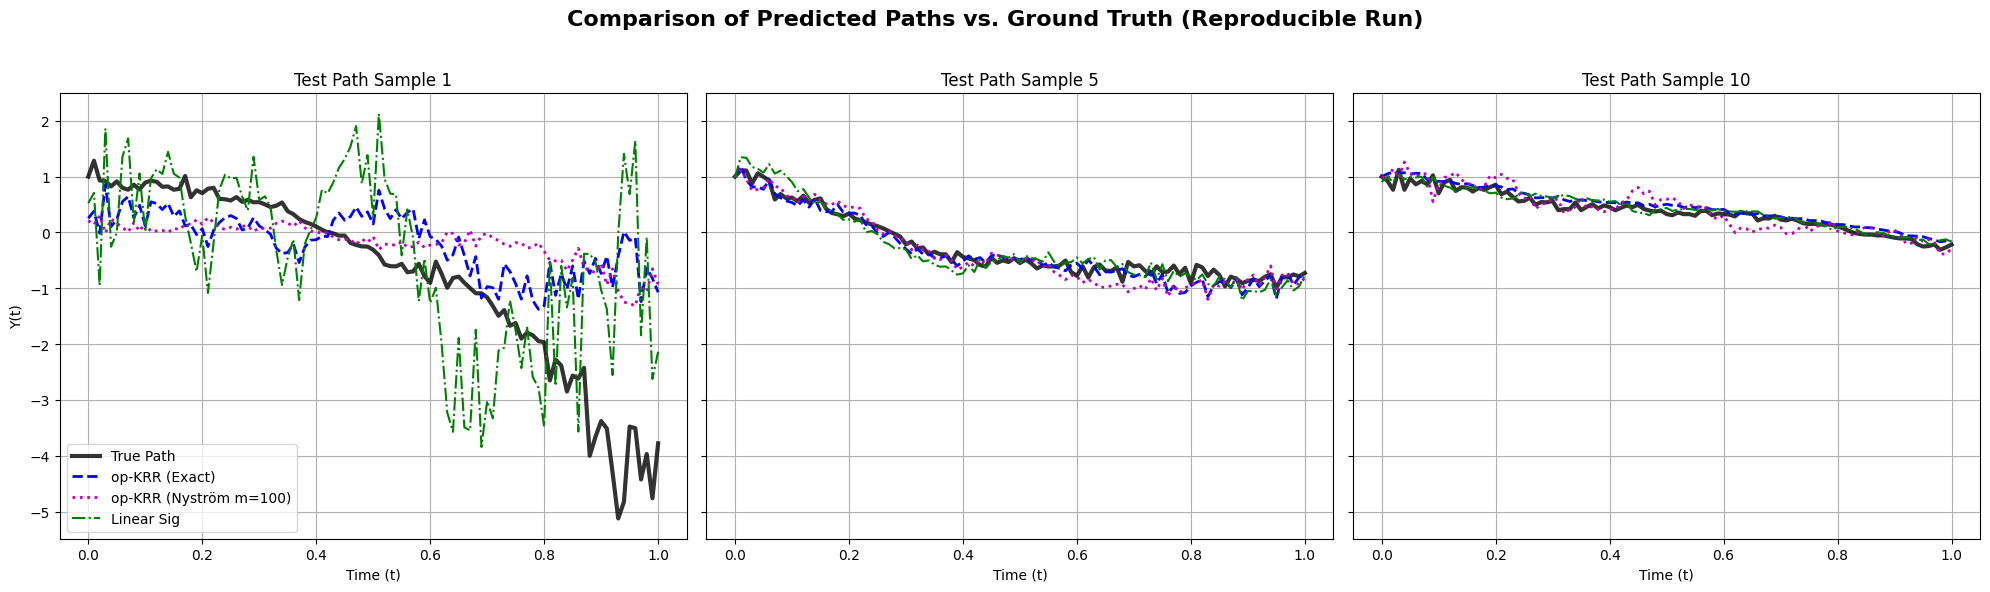

   - Calculating error distributions for boxplot...


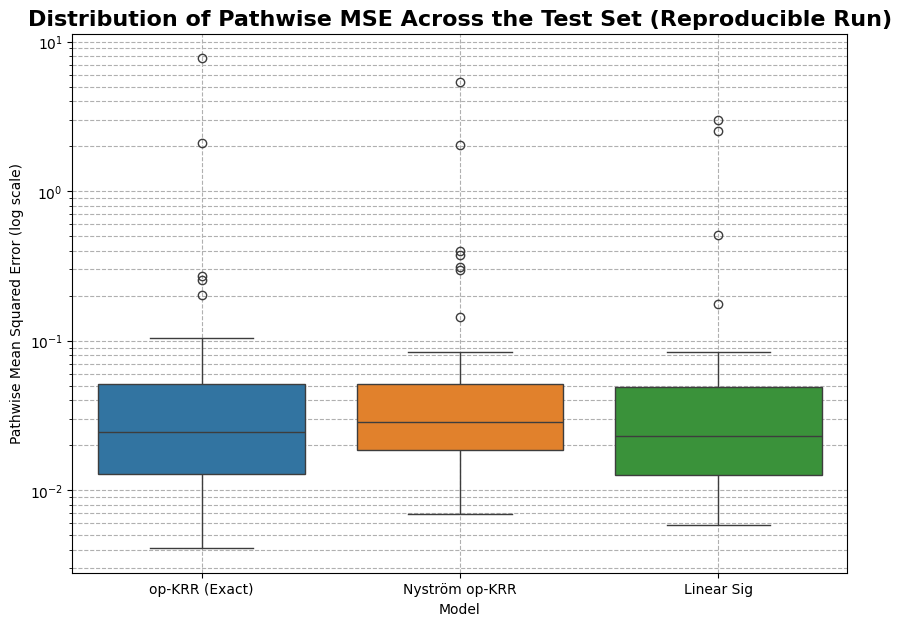


Experiment finished.


In [ ]:
# %% 0. Setup and Parameters
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import fbm
from iisignature import sig
from joblib import Parallel, delayed
import time

# --- ROBUSTNESS & REPRODUCIBILITY CONTROLS ---
NUM_RUNS = 10
CANONICAL_SEED = 42

# --- Experiment Parameters ---
N_train = 500; N_test = 50; N_total = N_train + N_test
T = 1.0; n_steps = 100; H = 0.1; L = 5;dt = T / n_steps;
m_landmarks = 100
lambda_grid = [0.1, 0.3, 0.5, 0.7, 0.9]; gamma_grid = [1e-6, 1e-5, 1e-4]
cv_folds = 5; a_drift=0.5; b_drift_nonlinear=1; c_diffusion=0.25; Y0 = 1.0

# %% Helper Functions
def get_level_indices(l,d): s=(d**l-1)//(d-1); e=(d**(l+1)-1)//(d-1); return slice(s,e)
def signature_kernel(s1,s2,lam,L,d):
    dist_sq=sum((lam**(l-1))*np.sum((s1[get_level_indices(l,d)]-s2[get_level_indices(l,d)])**2) for l in range(1,L+1))
    return np.exp(-dist_sq)
def compute_gram_matrix(S, lam, L, d):
    n = S.shape[0]; s_reshaped = S[:, np.newaxis, :]; diffs = s_reshaped - S
    weights = np.zeros(S.shape[1])
    for l in range(1, L + 1): weights[get_level_indices(l, d)] = lam**(l - 1)
    dist_sq_matrix = np.sum((diffs**2) * weights, axis=2)
    return np.exp(-dist_sq_matrix)
def calculate_weighted_sig_error(s_true,s_pred,lam,L,d):
    err=sum((lam**(l-1))*np.sum((s_true[get_level_indices(l,d)]-s_pred[get_level_indices(l,d)])**2) for l in range(1,L+1))
    return np.sqrt(err)
class KernelPathInverter:
    def __init__(self,l,g,L,d): self.l,self.g,self.L,self.d=l,g,L,d
    def fit(self,S,Y): self.S_train=S; K=compute_gram_matrix(S,self.l,self.L,self.d); self.C=np.linalg.solve(K+self.g*np.eye(S.shape[0]),Y); return self
    def predict(self,S_test):
        K_test=np.array([[signature_kernel(st,str,self.l,self.L,self.d) for str in self.S_train] for st in S_test])
        return K_test@self.C
class NystromOpKRR:
    def __init__(self, kernel_lambda, reg_gamma, n_landmarks, L, d):
        self.lam, self.gam, self.m, self.L, self.d = kernel_lambda, reg_gamma, n_landmarks, L, d
        self.S_landmarks_scaled_, self.coeffs_ = None, None
    def fit(self, S_X_scaled, S_Y):
        N = S_X_scaled.shape[0]
        if self.m > N: raise ValueError(f"Landmarks ({self.m}) > data points ({N}).")
        landmark_indices = np.random.choice(N, size=self.m, replace=False)
        self.S_landmarks_scaled_ = S_X_scaled[landmark_indices]
        K_mm = compute_gram_matrix(self.S_landmarks_scaled_, self.lam, self.L, self.d)
        K_Nm = np.array([[signature_kernel(s, sl, self.lam, self.L, self.d) for sl in self.S_landmarks_scaled_] for s in S_X_scaled])
        gamma_eff = self.gam * N
        M = K_mm + (K_Nm.T @ K_Nm) / gamma_eff
        self.coeffs_ = np.linalg.solve(M, K_Nm.T @ S_Y) / gamma_eff
        return self
    def predict(self, S_X_test_scaled):
        if self.coeffs_ is None: raise RuntimeError("Model must be fit first.")
        K_test_m = np.array([[signature_kernel(st, sl, self.lam, self.L, self.d) for sl in self.S_landmarks_scaled_] for st in S_X_test_scaled])
        return K_test_m @ self.coeffs_

# %% 1. ROBUSTNESS ANALYSIS: Run experiment multiple times
all_run_metrics = []
print(f"--- Starting Robustness Analysis: {NUM_RUNS} runs with different seeds ---")

#
def generate_sde_golden_mean_path(seed):
    np.random.seed(seed)
    x_path = fbm.fbm(n=n_steps, hurst=H, length=T, method='daviesharte')
    y_path = np.zeros(n_steps + 1); y_path[0] = Y0
    for j in range(n_steps): y_path[j+1] = y_path[j] + (a_drift*x_path[j]+b_drift_nonlinear*x_path[j]**3)*dt + c_diffusion*y_path[j]*(x_path[j+1]-x_path[j])
    return x_path, y_path

for run_idx in range(NUM_RUNS):

    master_seed = run_idx
    np.random.seed(master_seed)
    print(f"\n--- Starting Run {run_idx + 1}/{NUM_RUNS} (Seed: {master_seed}) ---")

    # --- Data Generation ---
    worker_seeds = np.random.randint(0, 2**32 - 1, size=N_total)
    results = Parallel(n_jobs=-1)(delayed(generate_sde_golden_mean_path)(seed) for seed in worker_seeds)

    X_paths = np.array([res[0] for res in results]); Y_paths = np.array([res[1] for res in results])
    X_train, X_test = X_paths[:N_train], X_paths[N_train:]; Y_train, Y_test = Y_paths[:N_train], Y_paths[N_train:]
    t_span = np.linspace(0, T, n_steps + 1)

    # --- Feature Computation
    path_dim = 2
    def get_signatures_for_paths(paths):
        combined = [np.column_stack((t_span, p)) for p in paths]
        return np.array(Parallel(n_jobs=-1)(delayed(sig)(p, L) for p in combined))
    S_X_train, S_Y_train = get_signatures_for_paths(X_train), get_signatures_for_paths(Y_train)
    S_X_test, S_Y_test = get_signatures_for_paths(X_test), get_signatures_for_paths(Y_test)
    scaler = StandardScaler(); S_X_train_scaled = scaler.fit_transform(S_X_train); S_X_test_scaled = scaler.transform(S_X_test)

    kf, best_score, best_lambda, best_gamma = KFold(n_splits=cv_folds), float('inf'), None, None
    for lam in lambda_grid:
        K = compute_gram_matrix(S_X_train_scaled, lam, L, path_dim)
        for gam in gamma_grid:
            scores = [mean_squared_error(S_Y_train[v], K[v][:,t] @ np.linalg.solve(K[t][:,t]+gam*np.eye(len(t)), S_Y_train[t])) for t,v in kf.split(S_X_train_scaled)]
            if np.mean(scores) < best_score: best_score, best_lambda, best_gamma = np.mean(scores), lam, gam
    K_final = compute_gram_matrix(S_X_train_scaled, best_lambda, L, path_dim)
    C_opKRR = np.linalg.solve(K_final + best_gamma * np.eye(N_train), S_Y_train)
    nystrom_model = NystromOpKRR(best_lambda, best_gamma, m_landmarks, L, path_dim).fit(S_X_train_scaled, S_Y_train)
    linear_model = RidgeCV(alphas=np.logspace(-2, 4, 10)).fit(S_X_train_scaled, S_Y_train)
    path_inverter = KernelPathInverter(best_lambda, best_gamma, L, path_dim).fit(S_Y_train, Y_train)
    K_test = np.array([[signature_kernel(st, str_train, best_lambda, L, path_dim) for str_train in S_X_train_scaled] for st in S_X_test_scaled])
    S_Y_pred_opKRR = K_test @ C_opKRR
    S_Y_pred_nystrom = nystrom_model.predict(S_X_test_scaled)
    S_Y_pred_linear = linear_model.predict(S_X_test_scaled)
    metrics_opKRR = {'run_seed': run_idx, 'model': 'op-KRR (Exact)', 'pathwise_mse': np.mean(np.trapezoid((Y_test - path_inverter.predict(S_Y_pred_opKRR))**2, t_span, axis=1)), 'weighted_sig_error': np.mean([calculate_weighted_sig_error(S_Y_test[i],S_Y_pred_opKRR[i],best_lambda,L,path_dim) for i in range(N_test)])}
    metrics_nystrom = {'run_seed': run_idx, 'model': 'Nyström op-KRR', 'pathwise_mse': np.mean(np.trapezoid((Y_test - path_inverter.predict(S_Y_pred_nystrom))**2, t_span, axis=1)), 'weighted_sig_error': np.mean([calculate_weighted_sig_error(S_Y_test[i],S_Y_pred_nystrom[i],best_lambda,L,path_dim) for i in range(N_test)])}
    metrics_linear = {'run_seed': run_idx, 'model': 'Linear Sig', 'pathwise_mse': np.mean(np.trapezoid((Y_test - path_inverter.predict(S_Y_pred_linear))**2, t_span, axis=1)), 'weighted_sig_error': np.mean([calculate_weighted_sig_error(S_Y_test[i],S_Y_pred_linear[i],best_lambda,L,path_dim) for i in range(N_test)])}
    all_run_metrics.extend([metrics_opKRR, metrics_nystrom, metrics_linear])
    print(f"   ...Run {run_idx + 1} complete. Exact Path MSE: {metrics_opKRR['pathwise_mse']:.3f}")

# %% 2. AGGREGATED RESULTS ANALYSIS
print("\n\n--- AGGREGATED STATISTICAL RESULTS ---")
results_df = pd.DataFrame(all_run_metrics)
summary_stats = results_df.groupby('model')[['pathwise_mse', 'weighted_sig_error']].agg(['mean', 'std'])
summary_stats.columns = ['_'.join(col).strip() for col in summary_stats.columns.values]
summary_stats['Pathwise MSE (Mean ± Std)'] = summary_stats.apply(lambda r: f"{r['pathwise_mse_mean']:.3f} ± {r['pathwise_mse_std']:.3f}", axis=1)
summary_stats['Weighted Sig Error (Mean ± Std)'] = summary_stats.apply(lambda r: f"{r['weighted_sig_error_mean']:.2f} ± {r['weighted_sig_error_std']:.2f}", axis=1)
print("This is the robust results table for your paper:")
print(summary_stats[['Pathwise MSE (Mean ± Std)', 'Weighted Sig Error (Mean ± Std)']])

# %% 3. GENERATE FINAL REPRODUCIBLE FIGURES
print(f"\n--- Generating Final Reproducible Figures (using canonical seed: {CANONICAL_SEED}) ---")
np.random.seed(CANONICAL_SEED)

# --- Re-run the entire experiment logic once for the plots ---
print("   - Generating data...")
worker_seeds = np.random.randint(0, 2**32 - 1, size=N_total)
results = Parallel(n_jobs=-1)(delayed(generate_sde_golden_mean_path)(seed) for seed in worker_seeds)
X_paths = np.array([res[0] for res in results]); Y_paths = np.array([res[1] for res in results])
X_train, X_test = X_paths[:N_train], X_paths[N_train:]; Y_train, Y_test = Y_paths[:N_train], Y_paths[N_train:]
t_span = np.linspace(0, T, n_steps + 1)

print("   - Computing signatures and scaling...")
path_dim = 2
def get_signatures_for_paths(paths):
    combined = [np.column_stack((t_span, p)) for p in paths]
    return np.array(Parallel(n_jobs=-1)(delayed(sig)(p, L) for p in combined))
S_X_train, S_Y_train = get_signatures_for_paths(X_train), get_signatures_for_paths(Y_train)
S_X_test, S_Y_test = get_signatures_for_paths(X_test), get_signatures_for_paths(Y_test)
scaler = StandardScaler(); S_X_train_scaled = scaler.fit_transform(S_X_train); S_X_test_scaled = scaler.transform(S_X_test)
print("   - Training models...")
kf, best_score, best_lambda, best_gamma = KFold(n_splits=cv_folds), float('inf'), None, None
for lam in lambda_grid:
    K = compute_gram_matrix(S_X_train_scaled, lam, L, path_dim)
    for gam in gamma_grid:
        scores = [mean_squared_error(S_Y_train[v], K[v][:,t] @ np.linalg.solve(K[t][:,t]+gam*np.eye(len(t)), S_Y_train[t])) for t,v in kf.split(S_X_train_scaled)]
        if np.mean(scores) < best_score: best_score, best_lambda, best_gamma = np.mean(scores), lam, gam
K_final = compute_gram_matrix(S_X_train_scaled, best_lambda, L, path_dim)
C_opKRR = np.linalg.solve(K_final + best_gamma * np.eye(N_train), S_Y_train)
nystrom_model = NystromOpKRR(best_lambda, best_gamma, m_landmarks, L, path_dim).fit(S_X_train_scaled, S_Y_train)
linear_model = RidgeCV(alphas=np.logspace(-2, 4, 10)).fit(S_X_train_scaled, S_Y_train)
print("   - Generating predictions...")
path_inverter = KernelPathInverter(best_lambda, best_gamma, L, path_dim).fit(S_Y_train, Y_train)
K_test = np.array([[signature_kernel(st, str_train, best_lambda, L, path_dim) for str_train in S_X_train_scaled] for st in S_X_test_scaled])
S_Y_pred_opKRR = K_test @ C_opKRR; Y_pred_opKRR = path_inverter.predict(S_Y_pred_opKRR)
S_Y_pred_nystrom = nystrom_model.predict(S_X_test_scaled); Y_pred_nystrom = path_inverter.predict(S_Y_pred_nystrom)
S_Y_pred_linear = linear_model.predict(S_X_test_scaled); Y_pred_linear = path_inverter.predict(S_Y_pred_linear)

# %% 4. FINAL VISUALIZATIONS
print("   - Creating final plots...")

# --- Plot 1: Example Path Comparisons ---
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
plot_indices = [1, 5, 10]
for i, idx in enumerate(plot_indices):
    ax = axes[i];
    ax.plot(t_span,Y_test[idx,:],'k-',linewidth=3.0,label='True Path', alpha=0.8)
    ax.plot(t_span,Y_pred_opKRR[idx,:],'b--',linewidth=2.0,label='op-KRR (Exact)')
    ax.plot(t_span,Y_pred_nystrom[idx,:],'m:',linewidth=2.0,label=f'op-KRR (Nyström m={m_landmarks})')
    ax.plot(t_span,Y_pred_linear[idx,:],'g-.',linewidth=1.5,label='Linear Sig')
    ax.set_title(f'Test Path Sample {idx}'); ax.set_xlabel('Time (t)'); ax.grid(True)
    if i == 0: ax.set_ylabel('Y(t)'); ax.legend()
fig.suptitle('Comparison of Predicted Paths vs. Ground Truth (Reproducible Run)', fontsize=16, fontweight='bold'); plt.tight_layout(rect=[0,0,1,0.96]); plt.show()


# --- Plot 2: Boxplot of Errors ---
print("   - Calculating error distributions for boxplot...")
errors_opKRR = [np.trapezoid((Y_test[i] - Y_pred_opKRR[i])**2, t_span) for i in range(N_test)]
errors_nystrom = [np.trapezoid((Y_test[i] - Y_pred_nystrom[i])**2, t_span) for i in range(N_test)]
errors_linear = [np.trapezoid((Y_test[i] - Y_pred_linear[i])**2, t_span) for i in range(N_test)]

error_data = pd.DataFrame({
    'op-KRR (Exact)': errors_opKRR,
    'Nyström op-KRR': errors_nystrom,
    'Linear Sig': errors_linear
})

plt.figure(figsize=(10, 7))
sns.boxplot(data=error_data)
plt.title('Distribution of Pathwise MSE Across the Test Set (Reproducible Run)', fontsize=16, fontweight='bold')
plt.ylabel('Pathwise Mean Squared Error (log scale)')
plt.xlabel('Model')
plt.yscale('log')
plt.grid(True, which="both", ls="--")
plt.show()

print('\nExperiment finished.')

--- Starting Robustness Analysis: 10 runs with different seeds ---

--- Starting Run 1/10 (Seed: 0) ---
   ...Run 1 complete. Exact Path MSE: 1.194

--- Starting Run 2/10 (Seed: 1) ---
   ...Run 2 complete. Exact Path MSE: 0.984

--- Starting Run 3/10 (Seed: 2) ---
   ...Run 3 complete. Exact Path MSE: 1.987

--- Starting Run 4/10 (Seed: 3) ---
   ...Run 4 complete. Exact Path MSE: 1.646

--- Starting Run 5/10 (Seed: 4) ---
   ...Run 5 complete. Exact Path MSE: 0.654

--- Starting Run 6/10 (Seed: 5) ---
   ...Run 6 complete. Exact Path MSE: 0.379

--- Starting Run 7/10 (Seed: 6) ---
   ...Run 7 complete. Exact Path MSE: 0.279

--- Starting Run 8/10 (Seed: 7) ---
   ...Run 8 complete. Exact Path MSE: 0.134

--- Starting Run 9/10 (Seed: 8) ---
   ...Run 9 complete. Exact Path MSE: 0.282

--- Starting Run 10/10 (Seed: 9) ---
   ...Run 10 complete. Exact Path MSE: 0.169


--- AGGREGATED STATISTICAL RESULTS ---
This is the robust results table for your paper:
               Pathwise MSE (Me

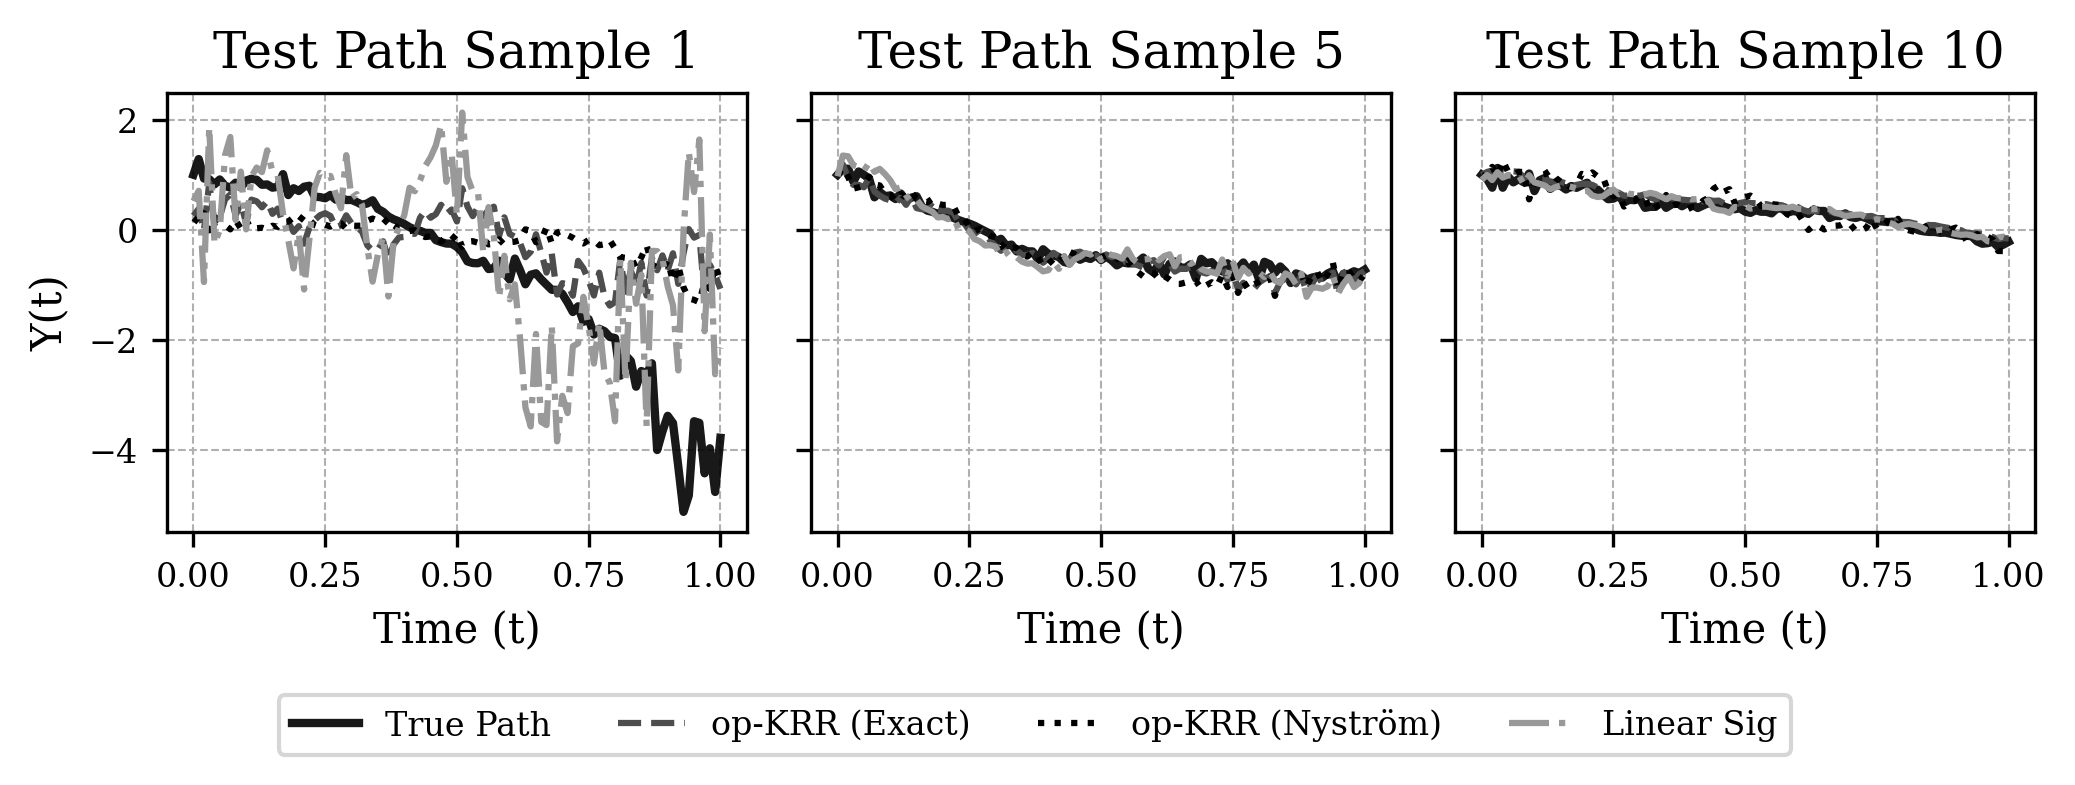

   - Calculating error distributions for boxplot...


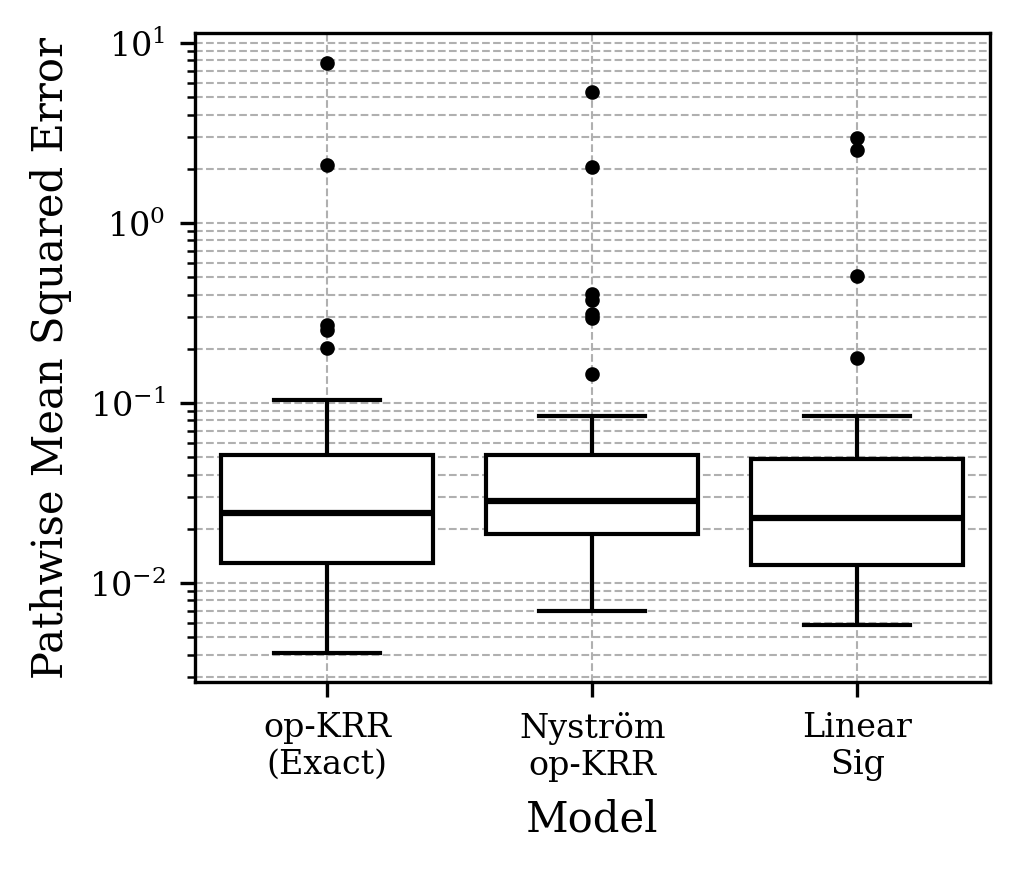


Experiment finished.


In [ ]:
# %% 0. Setup and Parameters
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import fbm
from iisignature import sig
from joblib import Parallel, delayed
import time

# --- ROBUSTNESS & REPRODUCIBILITY CONTROLS ---
NUM_RUNS = 10
CANONICAL_SEED = 42

# --- Experiment Parameters ---
N_train = 500; N_test = 50; N_total = N_train + N_test
T = 1.0; n_steps = 100; H = 0.1; L = 5;dt = T / n_steps;
m_landmarks = 100
lambda_grid = [0.1, 0.3, 0.5, 0.7, 0.9]; gamma_grid = [1e-6, 1e-5, 1e-4]
cv_folds = 5; a_drift=0.5; b_drift_nonlinear=1; c_diffusion=0.25; Y0 = 1.0

# %% Helper Functions
def get_level_indices(l,d): s=(d**l-1)//(d-1); e=(d**(l+1)-1)//(d-1); return slice(s,e)
def signature_kernel(s1,s2,lam,L,d):
    dist_sq=sum((lam**(l-1))*np.sum((s1[get_level_indices(l,d)]-s2[get_level_indices(l,d)])**2) for l in range(1,L+1))
    return np.exp(-dist_sq)
def compute_gram_matrix(S, lam, L, d):
    n = S.shape[0]; s_reshaped = S[:, np.newaxis, :]; diffs = s_reshaped - S
    weights = np.zeros(S.shape[1])
    for l in range(1, L + 1): weights[get_level_indices(l, d)] = lam**(l - 1)
    dist_sq_matrix = np.sum((diffs**2) * weights, axis=2)
    return np.exp(-dist_sq_matrix)
def calculate_weighted_sig_error(s_true,s_pred,lam,L,d):
    err=sum((lam**(l-1))*np.sum((s_true[get_level_indices(l,d)]-s_pred[get_level_indices(l,d)])**2) for l in range(1,L+1))
    return np.sqrt(err)
class KernelPathInverter:
    def __init__(self,l,g,L,d): self.l,self.g,self.L,self.d=l,g,L,d
    def fit(self,S,Y): self.S_train=S; K=compute_gram_matrix(S,self.l,self.L,self.d); self.C=np.linalg.solve(K+self.g*np.eye(S.shape[0]),Y); return self
    def predict(self,S_test):
        K_test=np.array([[signature_kernel(st,str,self.l,self.L,self.d) for str in self.S_train] for st in S_test])
        return K_test@self.C
class NystromOpKRR:
    def __init__(self, kernel_lambda, reg_gamma, n_landmarks, L, d):
        self.lam, self.gam, self.m, self.L, self.d = kernel_lambda, reg_gamma, n_landmarks, L, d
        self.S_landmarks_scaled_, self.coeffs_ = None, None
    def fit(self, S_X_scaled, S_Y):
        N = S_X_scaled.shape[0]
        if self.m > N: raise ValueError(f"Landmarks ({self.m}) > data points ({N}).")
        landmark_indices = np.random.choice(N, size=self.m, replace=False)
        self.S_landmarks_scaled_ = S_X_scaled[landmark_indices]
        K_mm = compute_gram_matrix(self.S_landmarks_scaled_, self.lam, self.L, self.d)
        K_Nm = np.array([[signature_kernel(s, sl, self.lam, self.L, self.d) for sl in self.S_landmarks_scaled_] for s in S_X_scaled])
        gamma_eff = self.gam * N
        M = K_mm + (K_Nm.T @ K_Nm) / gamma_eff
        self.coeffs_ = np.linalg.solve(M, K_Nm.T @ S_Y) / gamma_eff
        return self
    def predict(self, S_X_test_scaled):
        if self.coeffs_ is None: raise RuntimeError("Model must be fit first.")
        K_test_m = np.array([[signature_kernel(st, sl, self.lam, self.L, self.d) for sl in self.S_landmarks_scaled_] for st in S_X_test_scaled])
        return K_test_m @ self.coeffs_

# %% 1. ROBUSTNESS ANALYSIS: Run experiment multiple times
# (This section is unchanged, it runs the background calculations)
all_run_metrics = []
print(f"--- Starting Robustness Analysis: {NUM_RUNS} runs with different seeds ---")
def generate_sde_golden_mean_path(seed):
    np.random.seed(seed)
    x_path = fbm.fbm(n=n_steps, hurst=H, length=T, method='daviesharte')
    y_path = np.zeros(n_steps + 1); y_path[0] = Y0
    for j in range(n_steps): y_path[j+1] = y_path[j] + (a_drift*x_path[j]+b_drift_nonlinear*x_path[j]**3)*dt + c_diffusion*y_path[j]*(x_path[j+1]-x_path[j])
    return x_path, y_path
for run_idx in range(NUM_RUNS):
    master_seed = run_idx
    np.random.seed(master_seed)
    print(f"\n--- Starting Run {run_idx + 1}/{NUM_RUNS} (Seed: {master_seed}) ---")
    worker_seeds = np.random.randint(0, 2**32 - 1, size=N_total)
    results = Parallel(n_jobs=-1)(delayed(generate_sde_golden_mean_path)(seed) for seed in worker_seeds)
    X_paths = np.array([res[0] for res in results]); Y_paths = np.array([res[1] for res in results])
    X_train, X_test = X_paths[:N_train], X_paths[N_train:]; Y_train, Y_test = Y_paths[:N_train], Y_paths[N_train:]
    t_span = np.linspace(0, T, n_steps + 1)
    path_dim = 2
    def get_signatures_for_paths(paths):
        combined = [np.column_stack((t_span, p)) for p in paths]
        return np.array(Parallel(n_jobs=-1)(delayed(sig)(p, L) for p in combined))
    S_X_train, S_Y_train = get_signatures_for_paths(X_train), get_signatures_for_paths(Y_train)
    S_X_test, S_Y_test = get_signatures_for_paths(X_test), get_signatures_for_paths(Y_test)
    scaler = StandardScaler(); S_X_train_scaled = scaler.fit_transform(S_X_train); S_X_test_scaled = scaler.transform(S_X_test)
    kf, best_score, best_lambda, best_gamma = KFold(n_splits=cv_folds), float('inf'), None, None
    for lam in lambda_grid:
        K = compute_gram_matrix(S_X_train_scaled, lam, L, path_dim)
        for gam in gamma_grid:
            scores = [mean_squared_error(S_Y_train[v], K[v][:,t] @ np.linalg.solve(K[t][:,t]+gam*np.eye(len(t)), S_Y_train[t])) for t,v in kf.split(S_X_train_scaled)]
            if np.mean(scores) < best_score: best_score, best_lambda, best_gamma = np.mean(scores), lam, gam
    K_final = compute_gram_matrix(S_X_train_scaled, best_lambda, L, path_dim)
    C_opKRR = np.linalg.solve(K_final + best_gamma * np.eye(N_train), S_Y_train)
    nystrom_model = NystromOpKRR(best_lambda, best_gamma, m_landmarks, L, path_dim).fit(S_X_train_scaled, S_Y_train)
    linear_model = RidgeCV(alphas=np.logspace(-2, 4, 10)).fit(S_X_train_scaled, S_Y_train)
    path_inverter = KernelPathInverter(best_lambda, best_gamma, L, path_dim).fit(S_Y_train, Y_train)
    K_test = np.array([[signature_kernel(st, str_train, best_lambda, L, path_dim) for str_train in S_X_train_scaled] for st in S_X_test_scaled])
    S_Y_pred_opKRR = K_test @ C_opKRR
    S_Y_pred_nystrom = nystrom_model.predict(S_X_test_scaled)
    S_Y_pred_linear = linear_model.predict(S_X_test_scaled)
    metrics_opKRR = {'run_seed': run_idx, 'model': 'op-KRR (Exact)', 'pathwise_mse': np.mean(np.trapezoid((Y_test - path_inverter.predict(S_Y_pred_opKRR))**2, t_span, axis=1)), 'weighted_sig_error': np.mean([calculate_weighted_sig_error(S_Y_test[i],S_Y_pred_opKRR[i],best_lambda,L,path_dim) for i in range(N_test)])}
    metrics_nystrom = {'run_seed': run_idx, 'model': 'Nyström op-KRR', 'pathwise_mse': np.mean(np.trapezoid((Y_test - path_inverter.predict(S_Y_pred_nystrom))**2, t_span, axis=1)), 'weighted_sig_error': np.mean([calculate_weighted_sig_error(S_Y_test[i],S_Y_pred_nystrom[i],best_lambda,L,path_dim) for i in range(N_test)])}
    metrics_linear = {'run_seed': run_idx, 'model': 'Linear Sig', 'pathwise_mse': np.mean(np.trapezoid((Y_test - path_inverter.predict(S_Y_pred_linear))**2, t_span, axis=1)), 'weighted_sig_error': np.mean([calculate_weighted_sig_error(S_Y_test[i],S_Y_pred_linear[i],best_lambda,L,path_dim) for i in range(N_test)])}
    all_run_metrics.extend([metrics_opKRR, metrics_nystrom, metrics_linear])
    print(f"   ...Run {run_idx + 1} complete. Exact Path MSE: {metrics_opKRR['pathwise_mse']:.3f}")

# %% 2. AGGREGATED RESULTS ANALYSIS
# (This section is unchanged)
print("\n\n--- AGGREGATED STATISTICAL RESULTS ---")
results_df = pd.DataFrame(all_run_metrics)
summary_stats = results_df.groupby('model')[['pathwise_mse', 'weighted_sig_error']].agg(['mean', 'std'])
summary_stats.columns = ['_'.join(col).strip() for col in summary_stats.columns.values]
summary_stats['Pathwise MSE (Mean ± Std)'] = summary_stats.apply(lambda r: f"{r['pathwise_mse_mean']:.3f} ± {r['pathwise_mse_std']:.3f}", axis=1)
summary_stats['Weighted Sig Error (Mean ± Std)'] = summary_stats.apply(lambda r: f"{r['weighted_sig_error_mean']:.2f} ± {r['weighted_sig_error_std']:.2f}", axis=1)
print("This is the robust results table for your paper:")
print(summary_stats[['Pathwise MSE (Mean ± Std)', 'Weighted Sig Error (Mean ± Std)']])

# %% 3. GENERATE FINAL REPRODUCIBLE FIGURES
# (This section is unchanged, it runs the background calculations for the final plots)
print(f"\n--- Generating Final Reproducible Figures (using canonical seed: {CANONICAL_SEED}) ---")
np.random.seed(CANONICAL_SEED)
print("   - Generating data...")
worker_seeds = np.random.randint(0, 2**32 - 1, size=N_total)
results = Parallel(n_jobs=-1)(delayed(generate_sde_golden_mean_path)(seed) for seed in worker_seeds)
X_paths = np.array([res[0] for res in results]); Y_paths = np.array([res[1] for res in results])
X_train, X_test = X_paths[:N_train], X_paths[N_train:]; Y_train, Y_test = Y_paths[:N_train], Y_paths[N_train:]
t_span = np.linspace(0, T, n_steps + 1)
print("   - Computing signatures and scaling...")
path_dim = 2
def get_signatures_for_paths(paths):
    combined = [np.column_stack((t_span, p)) for p in paths]
    return np.array(Parallel(n_jobs=-1)(delayed(sig)(p, L) for p in combined))
S_X_train, S_Y_train = get_signatures_for_paths(X_train), get_signatures_for_paths(Y_train)
S_X_test, S_Y_test = get_signatures_for_paths(X_test), get_signatures_for_paths(Y_test)
scaler = StandardScaler(); S_X_train_scaled = scaler.fit_transform(S_X_train); S_X_test_scaled = scaler.transform(S_X_test)
print("   - Training models...")
kf, best_score, best_lambda, best_gamma = KFold(n_splits=cv_folds), float('inf'), None, None
for lam in lambda_grid:
    K = compute_gram_matrix(S_X_train_scaled, lam, L, path_dim)
    for gam in gamma_grid:
        scores = [mean_squared_error(S_Y_train[v], K[v][:,t] @ np.linalg.solve(K[t][:,t]+gam*np.eye(len(t)), S_Y_train[t])) for t,v in kf.split(S_X_train_scaled)]
        if np.mean(scores) < best_score: best_score, best_lambda, best_gamma = np.mean(scores), lam, gam
K_final = compute_gram_matrix(S_X_train_scaled, best_lambda, L, path_dim)
C_opKRR = np.linalg.solve(K_final + best_gamma * np.eye(N_train), S_Y_train)
nystrom_model = NystromOpKRR(best_lambda, best_gamma, m_landmarks, L, path_dim).fit(S_X_train_scaled, S_Y_train)
linear_model = RidgeCV(alphas=np.logspace(-2, 4, 10)).fit(S_X_train_scaled, S_Y_train)
print("   - Generating predictions...")
path_inverter = KernelPathInverter(best_lambda, best_gamma, L, path_dim).fit(S_Y_train, Y_train)
K_test = np.array([[signature_kernel(st, str_train, best_lambda, L, path_dim) for str_train in S_X_train_scaled] for st in S_X_test_scaled])
S_Y_pred_opKRR = K_test @ C_opKRR; Y_pred_opKRR = path_inverter.predict(S_Y_pred_opKRR)
S_Y_pred_nystrom = nystrom_model.predict(S_X_test_scaled); Y_pred_nystrom = path_inverter.predict(S_Y_pred_nystrom)
S_Y_pred_linear = linear_model.predict(S_X_test_scaled); Y_pred_linear = path_inverter.predict(S_Y_pred_linear)


# %% 4. FINAL VISUALIZATIONS (MODIFIED FOR B&W PUBLICATION STYLE)
print("   - Creating final B&W plots...")

# --- NEW: Set Publication-Quality Plotting Parameters ---
# These settings will apply to all subsequent plots in this cell.
plt.rcParams.update({
    "font.family": "serif",  # Use a serif font like Times New Roman
    "font.size": 10,         # Base font size
    "axes.labelsize": 10,    # X and Y axis labels
    "axes.titlesize": 12,    # Subplot titles
    "xtick.labelsize": 8,    # X-axis tick labels
    "ytick.labelsize": 8,    # Y-axis tick labels
    "legend.fontsize": 8,    # Legend font size
    "lines.linewidth": 1.5,  # Make plot lines thicker
})

# --- NEW: Define the Black and White styles ---
BW_STYLES = {
    "ground_truth": {'color':'black', 'linestyle':'-'},
    "opKRR_exact":  {'color':'0.3',   'linestyle':'--'}, # Dark gray, dashed
    "nystrom":      {'color':'0.0',   'linestyle':':'},  # Black, dotted
    "linear":       {'color':'0.6',   'linestyle':'-.'}, # Light gray, dash-dot
}

# --- Plot 1: Example Path Comparisons (MODIFIED) ---
# Sized for a typical full-width figure in a two-column paper (~7 inches)
fig, axes = plt.subplots(1, 3, figsize=(7, 2.5), sharey=True, dpi=300)
plot_indices = [1, 5, 10]

for i, idx in enumerate(plot_indices):
    ax = axes[i]
    # Use the BW_STYLES dictionary to style each line
    ax.plot(t_span, Y_test[idx,:], linewidth=2.0, label='True Path', alpha=0.9, **BW_STYLES['ground_truth'])
    ax.plot(t_span, Y_pred_opKRR[idx,:], label='op-KRR (Exact)', **BW_STYLES['opKRR_exact'])
    ax.plot(t_span, Y_pred_nystrom[idx,:], label=f'op-KRR (Nyström)', **BW_STYLES['nystrom'])
    ax.plot(t_span, Y_pred_linear[idx,:], label='Linear Sig', **BW_STYLES['linear'])
    ax.set_title(f'Test Path Sample {idx}')
    ax.set_xlabel('Time (t)')
    ax.grid(True, which="both", ls="--", linewidth=0.5)
    if i == 0:
        ax.set_ylabel('Y(t)')

# Place a single, shared legend below the plots for a cleaner look
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.05))
plt.tight_layout(rect=[0, 0.05, 1, 1]) # Adjust layout to make space for the legend
plt.show()


# --- Plot 2: Boxplot of Errors (MODIFIED) ---
print("   - Calculating error distributions for boxplot...")
errors_opKRR = [np.trapezoid((Y_test[i] - Y_pred_opKRR[i])**2, t_span) for i in range(N_test)]
errors_nystrom = [np.trapezoid((Y_test[i] - Y_pred_nystrom[i])**2, t_span) for i in range(N_test)]
errors_linear = [np.trapezoid((Y_test[i] - Y_pred_linear[i])**2, t_span) for i in range(N_test)]

error_data = pd.DataFrame({
    'op-KRR\n(Exact)': errors_opKRR,
    'Nyström\nop-KRR': errors_nystrom, # Use \n for line breaks in labels
    'Linear\nSig': errors_linear
})

# Sized for a single-column figure (~3.5 inches)
plt.figure(figsize=(3.5, 3), dpi=300)

# --- NEW: Define properties for a black and white boxplot ---
boxplot_props = {
    'boxprops': {'facecolor':'white', 'edgecolor':'black'},
    'medianprops': {'color':'black', 'linestyle':'-', 'linewidth': 1.5},
    'whiskerprops': {'color':'black'},
    'capprops': {'color':'black'},
    'flierprops': {'marker':'.', 'markerfacecolor':'black', 'markeredgecolor':'black', 'markersize': 5}
}

# Apply the B&W properties to the seaborn plot
sns.boxplot(data=error_data, **boxplot_props)

plt.ylabel('Pathwise Mean Squared Error')
plt.xlabel('Model')
plt.yscale('log')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()

print('\nExperiment finished.')